<a href="https://colab.research.google.com/github/jongbokhi/master_thesis_2023/blob/main/A2PM_Directly_attack_pretrained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install a2pm

In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score

from a2pm import A2PMethod
from a2pm.callbacks import BaseCallback, MetricCallback, TimeCallback
from a2pm.patterns import BasePattern, CombinationPattern, IntervalPattern
from a2pm.wrappers import BaseWrapper, KerasWrapper, SklearnWrapper, TorchWrapper

import warnings

# Ignore the warning about missing feature names
warnings.filterwarnings("ignore", category=UserWarning)

# **Check the vulnerability of pretrained ML models to adversarial attack** ##

I used 'A2PM' module

*   'A2PM'web page: https://a2pm.readthedocs.io/en/latest/intro.html#
*   A2PM research article: https://doi.org/10.3390/fi14040108



## Load pretrained ML models

In [ ]:
model_rf = joblib.load("/content/drive/MyDrive/saved_models/RandomForest_v2.pkl")
model_nb = joblib.load("/content/drive/MyDrive/saved_models/NaiveBayes_v2.pkl")
model_svc = joblib.load("/content/drive/MyDrive/saved_models/SVC_v2.pkl")
model_dt = joblib.load("/content/drive/MyDrive/saved_models/decisiontree_v2.pkl")
model_xgb = joblib.load("/content/drive/MyDrive/saved_models/XGBoost_v2.pkl")
model_lgbm = joblib.load("/content/drive/MyDrive/saved_models/Lightgbm_v2.pkl")
model_lg =  joblib.load("/content/drive/MyDrive/saved_models/logisticregression_v2.pkl")

## Load combined dataset(Fake Benign + Original data)


In [4]:
fake_df = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/fake_benign_df.csv')

In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/original_test.csv')

In [6]:
combined_df = pd.concat([test_df, fake_df], axis=0, ignore_index=False)

In [7]:
combined_df

,Bwd IAT Tot,Bwd Pkt Len Max,Flow Duration,Flow IAT Min,Fwd Header Len,Fwd IAT Mean,Fwd IAT Min,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Std,Fwd Pkts/s,Fwd Seg Size Min,Init Bwd Win Byts,Init Fwd Win Byts,Tot Bwd Pkts,TotLen Bwd Pkts,TotLen Fwd Pkts,Label
0,0.000000e+00,0.025000,0.000012,1.213694e-05,7.453509e-05,0.000000,0.000000e+00,0.001546,3.502825e-02,0.000000,1.717033e-04,0.181818,0.000000e+00,0.000000,1.296008e-04,4.185370e-06,3.613285e-06,0
1,4.171528e-02,0.517021,0.041707,5.001486e-08,1.267096e-03,0.000007,2.825839e-06,0.018805,0.000000e+00,0.042439,1.998050e-07,0.727273,3.356934e-03,0.410217,5.184033e-04,8.655701e-05,4.394221e-05,1
2,2.918810e-04,0.189362,0.034401,6.668648e-08,1.565237e-03,0.008603,2.000594e-07,0.046638,0.000000e+00,0.094140,3.027992e-07,0.727273,3.234863e-03,0.003357,3.888025e-04,3.170195e-05,1.089813e-04,0
3,6.354051e-04,0.167553,0.035455,5.835067e-08,1.565237e-03,0.008866,2.500743e-07,0.046638,0.000000e+00,0.094140,2.937970e-07,0.727273,3.234863e-03,0.003357,3.888025e-04,2.805088e-05,1.089813e-04,0
4,4.407622e-02,0.123404,0.044069,4.084547e-07,8.571535e-04,0.000335,9.336107e-07,0.004838,0.000000e+00,0.010919,1.890970e-07,0.454545,2.166748e-03,0.125015,5.184033e-04,2.065970e-05,1.130609e-05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19635,1.363973e-07,0.781875,0.000080,4.950707e-09,2.405331e-07,0.000039,1.658720e-08,0.015793,1.257573e-07,0.008791,6.479136e-23,0.444282,4.069308e-11,0.148486,4.427034e-19,5.112379e-07,1.562691e-18,0
19636,3.744506e-05,0.004653,0.002179,1.014142e-05,1.552505e-03,0.000269,6.259250e-05,0.001097,8.549034e-05,0.000489,1.166687e-02,0.487212,6.845594e-03,0.000732,1.896220e-05,1.079008e-06,4.488768e-06,0
19637,1.078365e-03,0.014979,0.008438,2.135566e-05,2.437885e-03,0.001019,9.396006e-05,0.005558,8.428859e-05,0.005483,7.861213e-02,0.512004,7.034119e-04,0.000382,3.691574e-03,1.081198e-07,3.926844e-03,0
19638,2.738117e-05,0.005401,0.001468,8.545368e-06,1.572378e-03,0.000172,5.145026e-05,0.000940,7.939383e-05,0.000455,6.823822e-03,0.485302,1.509294e-02,0.002050,9.683298e-06,4.400034e-06,2.434123e-06,0


In [8]:
##Sort the feature and Target variable
x_train = combined_df.drop('Label', axis=1).copy()
y_train = combined_df['Label'].copy()

In [9]:
y_train_df = pd.DataFrame(y_train, columns=['Label'])

In [10]:
# get only 'benign'
y_train_target = y_train_df[y_train_df["Label"] == 0]

In [11]:
pattern = (

    # First pattern to be applied: Interval
    {
        "type": "interval",
        "features": list(range(0, 20)),
        "integer_features": list(range(10, 20)),
        "ratio": 0.1,
        "max_ratio": 0.3,
        "missing_value": 0.0,
        "probability": 0.6,
    },

    # Second pattern to be applied: Combination
    {
        "type": "combination",
        "features": list(range(17, 40)),
        "locked_features": list(range(30, 40)),
        "probability": 0.4,
    },
)

method = A2PMethod(pattern)

In [12]:
# Create an instance of the IntervalPattern
pattern = IntervalPattern()

# Set the target label for malicious samples as 'Benign' (0)
pattern.partial_fit(x_train[y_train == 1])

# Create an instance of the A2PM classifier
a2pm_classifier = A2PMethod(pattern)

# Create the target labels array with the same shape as y_train
y_target = np.zeros_like(y_train)

# Generate the adversarial samples with the target label 'Benign' (0)
#X_adversarial = a2pm_classifier.fit_generate(clssifier, x_train, y_train, y_target)


In [14]:
## Single model

def MyCustomFunction(iteration, **kwargs):
    # Custom logic to be executed during each iteration
    print(f"Custom function called during iteration {iteration}")



class MyCustomCallback(BaseCallback):
    def __init__(self):
        super().__init__()

    def __call__(self, **kwargs):
        # Custom logic to be executed during each iteration
        print("Custom callback called")


class TimeCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose=verbose)
        self.values = []

    def __call__(self, **kwargs):
        iteration = kwargs.get("iteration")
        samples_left = kwargs.get("samples_left")
        samples_misclassified = kwargs.get("samples_misclassified")
        nanoseconds = kwargs.get("nanoseconds")

        seconds = nanoseconds / 1e9  # Convert nanoseconds to seconds

        if self.verbose == 2:
            print(f"Iteration: {iteration}, Time: {seconds:.2f} sec")

        self.values.append(seconds)




class MetricCallback(BaseCallback):
    def __init__(self, classifier, y, scorers=[('F1-Score', f1_score)], verbose=0):
        super().__init__(verbose)
        self.classifier = classifier
        self.classifier_name = model_names
        self.y = y
        self.scorers = scorers
        self.iterations = []
        self.scores = {description: [] for description, _ in scorers}

    def __call__(self, **kwargs):
        for description, scorer in self.scorers:
            if callable(scorer):
                if scorer == f1_score:
                    value = scorer(self.y, self.classifier.predict(kwargs['X']), average='macro')
                elif scorer == accuracy_score:
                    value = scorer(self.y, self.classifier.predict(kwargs['X']))
                elif scorer == recall_score:
                    value = scorer(self.y, self.classifier.predict(kwargs['X']), average='macro')
                else:
                    raise ValueError(f"Invalid scorer: {scorer}")

                self.scores[description].append(value)
            else:
                raise ValueError(f"Invalid scorer: {scorer}")

        self.iterations.append(kwargs['iteration'])

    def plot_scores(self):
      colors = ["red", "green", "blue"]  # Specify the desired colors

      for i, (description, _) in enumerate(self.scorers):
          plt.figure()
          plt.plot(self.iterations, self.scores[description], color=colors[i])
          plt.xlabel("Iteration")
          plt.ylabel(description)
          plt.title(f"{description} as Iterations Progress - {self.classifier_name}")
          plt.show()

#Untargeted attack against a classifier

In [ ]:
# Adapts to new data, and then performs an untargeted attack against a classifier

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 1.50 sec
Custom callback called
Iteration: 2, Time: 1.39 sec
Custom callback called
Iteration: 3, Time: 1.37 sec
Custom callback called
Iteration: 4, Time: 1.35 sec
Custom callback called
Iteration: 5, Time: 1.35 sec
Custom callback called
Iteration: 6, Time: 1.36 sec
Custom callback called
Iteration: 7, Time: 1.34 sec
Custom callback called
Iteration: 8, Time: 1.36 sec
Custom callback called
Iteration: 9, Time: 1.35 sec
Custom callback called
Iteration: 10, Time: 1.35 sec
Custom callback called
Iteration: 11, Time: 1.35 sec
Custom callback called
Iteration: 12, Time: 1.35 sec
Custom callback called
Iteration: 13, Time: 1.33 sec
Custom callback called
Iteration: 14, Time: 1.34 sec
Custom callback called
Iteration: 15, Time: 1.36 sec
Custom callback called
Iteration: 16, Time: 1.36 sec
Custom callback called
Iteration: 17, Time: 1.32 sec
Custom callback called
Iteration: 18, Time: 1.37 sec
Custom callback called
Ite

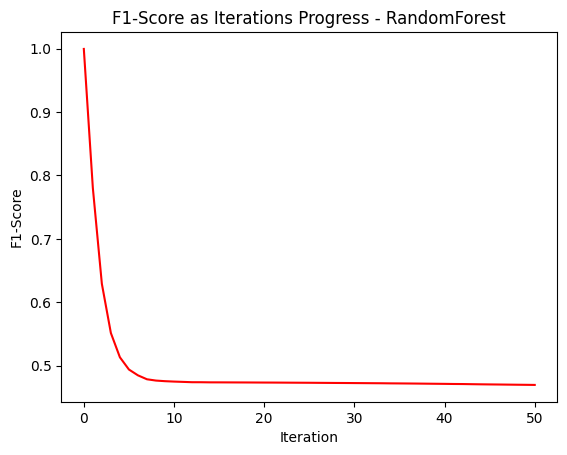

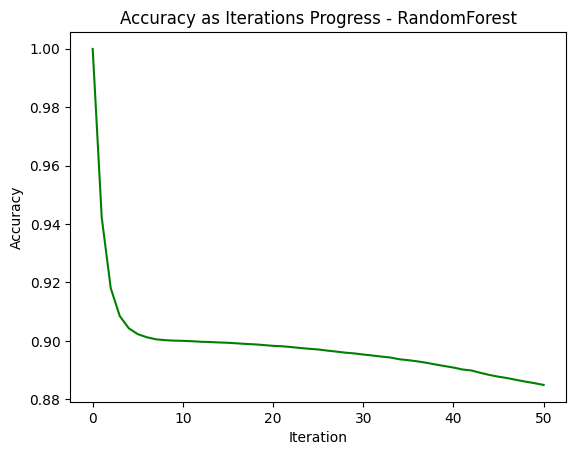

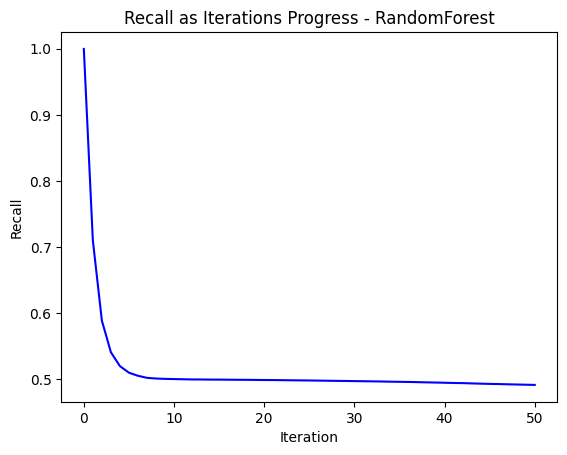

In [15]:
##RandomForest
model_names= 'RandomForest'
# Instantiate the callbacks
metric_callback_rf = MetricCallback(model_rf, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_rf = TimeCallback(verbose=2)
custom_callback_rf = MyCustomCallback()

# Configure the callbacks list
callbacks_rf = [metric_callback_rf, time_callback_rf, custom_callback_rf]

# Generate adversarial samples with callbacks
X_adversarial_rf = a2pm_classifier.fit_generate(model_rf, x_train, y_train, iterations=50, patience=2, callback = callbacks_rf)

# Plot the scores
metric_callback_rf.plot_scores()

In [16]:
f1_scores = [round(score, 3) for score in metric_callback_rf.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_rf.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_rf.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [1.0, 0.78, 0.629, 0.551, 0.513, 0.494, 0.485, 0.478, 0.476, 0.475, 0.475, 0.474, 0.474, 0.474, 0.474, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.472, 0.472, 0.472, 0.472, 0.472, 0.472, 0.472, 0.472, 0.472, 0.471, 0.471, 0.471, 0.471, 0.471, 0.471, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.469]
Max F1-Score: 1.0
Min F1-Score: 0.469

==================Accuracy Scores====================
Accuracy Scores: [1.0, 0.942, 0.918, 0.908, 0.904, 0.902, 0.901, 0.901, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.899, 0.899, 0.899, 0.899, 0.899, 0.899, 0.898, 0.898, 0.898, 0.898, 0.897, 0.897, 0.897, 0.896, 0.896, 0.896, 0.895, 0.895, 0.895, 0.894, 0.894, 0.893, 0.893, 0.892, 0.892, 0.891, 0.891, 0.89, 0.89, 0.889, 0.888, 0.888, 0.887, 0.887, 0.886, 0.885, 0.885]
Max Accuracy: 1.0
Min Accuracy: 0.885

==================Recall Scores====================
Recall Scores: [1.0, 0.71, 0.589, 0.541, 0.52, 0.

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 1.50 sec
Custom callback called
Iteration: 2, Time: 1.47 sec
Custom callback called
Iteration: 3, Time: 1.39 sec
Custom callback called
Iteration: 4, Time: 1.34 sec
Custom callback called
Iteration: 5, Time: 1.32 sec
Custom callback called
Iteration: 6, Time: 1.30 sec
Custom callback called
Iteration: 7, Time: 1.30 sec
Custom callback called
Iteration: 8, Time: 1.27 sec
Custom callback called
Iteration: 9, Time: 1.26 sec
Custom callback called
Iteration: 10, Time: 1.26 sec
Custom callback called
Iteration: 11, Time: 1.26 sec
Custom callback called
Iteration: 12, Time: 1.24 sec
Custom callback called
Iteration: 13, Time: 1.26 sec
Custom callback called
Iteration: 14, Time: 1.24 sec
Custom callback called
Iteration: 15, Time: 1.24 sec
Custom callback called
Iteration: 16, Time: 1.24 sec
Custom callback called
Iteration: 17, Time: 1.22 sec
Custom callback called
Iteration: 18, Time: 1.24 sec
Custom callback called
Ite

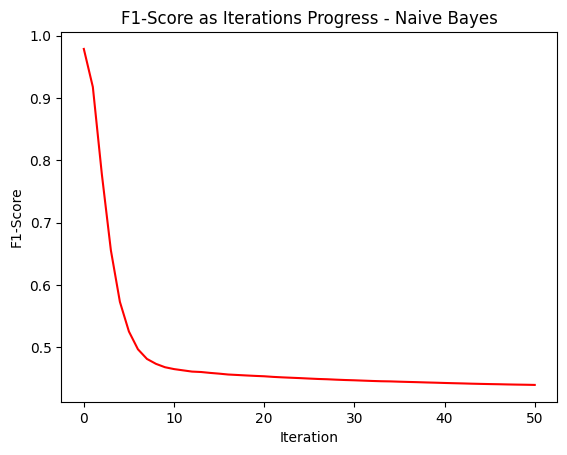

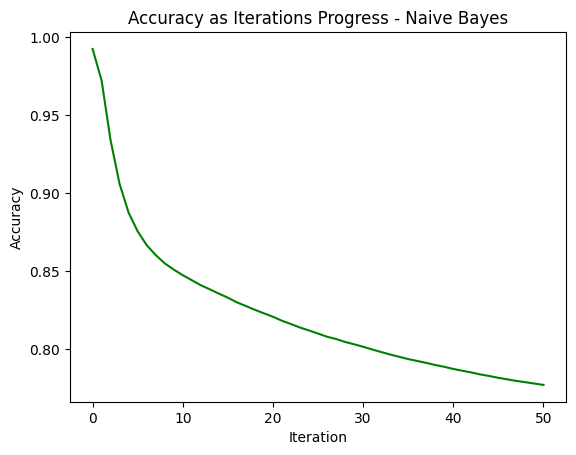

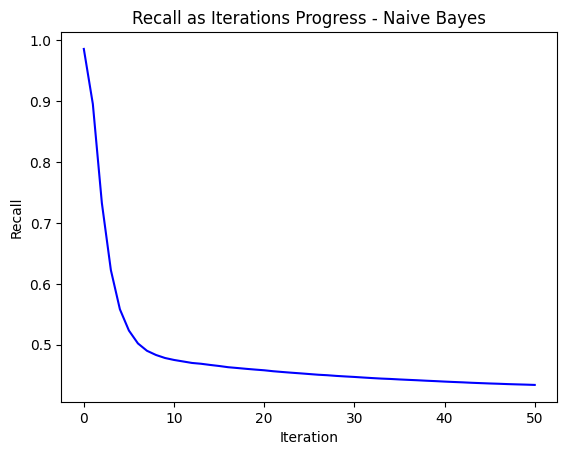

In [17]:
##Naive Bayes
model_names= 'Naive Bayes'
# Instantiate the callbacks
metric_callback_nb = MetricCallback(model_nb, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_nb = TimeCallback(verbose=2)
custom_callback_nb = MyCustomCallback()

# Configure the callbacks list
callbacks_nb = [metric_callback_nb, time_callback_nb, custom_callback_nb]

# Generate adversarial samples with callbacks
X_adversarial_nb = a2pm_classifier.fit_generate(model_nb, x_train, y_train, iterations=50, patience=2, callback = callbacks_nb)


# Plot the scores
metric_callback_nb.plot_scores()

In [18]:
f1_scores = [round(score, 3) for score in metric_callback_nb.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_nb.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_nb.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.979, 0.918, 0.778, 0.656, 0.573, 0.525, 0.497, 0.481, 0.474, 0.468, 0.465, 0.463, 0.461, 0.46, 0.459, 0.458, 0.456, 0.456, 0.455, 0.454, 0.454, 0.453, 0.452, 0.451, 0.451, 0.45, 0.449, 0.449, 0.448, 0.448, 0.447, 0.447, 0.446, 0.446, 0.445, 0.445, 0.445, 0.444, 0.444, 0.443, 0.443, 0.443, 0.442, 0.442, 0.441, 0.441, 0.441, 0.441, 0.44, 0.44, 0.44]
Max F1-Score: 0.979
Min F1-Score: 0.44

==================Accuracy Scores====================
Accuracy Scores: [0.992, 0.972, 0.934, 0.906, 0.887, 0.875, 0.867, 0.86, 0.855, 0.851, 0.847, 0.844, 0.841, 0.838, 0.836, 0.833, 0.83, 0.828, 0.825, 0.823, 0.821, 0.818, 0.816, 0.814, 0.812, 0.81, 0.808, 0.806, 0.805, 0.803, 0.801, 0.8, 0.798, 0.797, 0.795, 0.794, 0.792, 0.791, 0.79, 0.789, 0.787, 0.786, 0.785, 0.784, 0.783, 0.782, 0.781, 0.78, 0.779, 0.778, 0.777]
Max Accuracy: 0.992
Min Accuracy: 0.777

==================Recall Scores====================
Recall Scores: [0.986, 0.895, 0.7

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 1.46 sec
Custom callback called
Iteration: 2, Time: 1.45 sec
Custom callback called
Iteration: 3, Time: 1.40 sec
Custom callback called
Iteration: 4, Time: 1.35 sec
Custom callback called
Iteration: 5, Time: 1.31 sec
Custom callback called
Iteration: 6, Time: 1.28 sec
Custom callback called
Iteration: 7, Time: 1.25 sec
Custom callback called
Iteration: 8, Time: 1.21 sec
Custom callback called
Iteration: 9, Time: 1.18 sec
Custom callback called
Iteration: 10, Time: 1.15 sec
Custom callback called
Iteration: 11, Time: 1.11 sec
Custom callback called
Iteration: 12, Time: 1.09 sec
Custom callback called
Iteration: 13, Time: 1.07 sec
Custom callback called
Iteration: 14, Time: 1.03 sec
Custom callback called
Iteration: 15, Time: 1.02 sec
Custom callback called
Iteration: 16, Time: 0.98 sec
Custom callback called
Iteration: 17, Time: 0.96 sec
Custom callback called
Iteration: 18, Time: 0.93 sec
Custom callback called
Ite

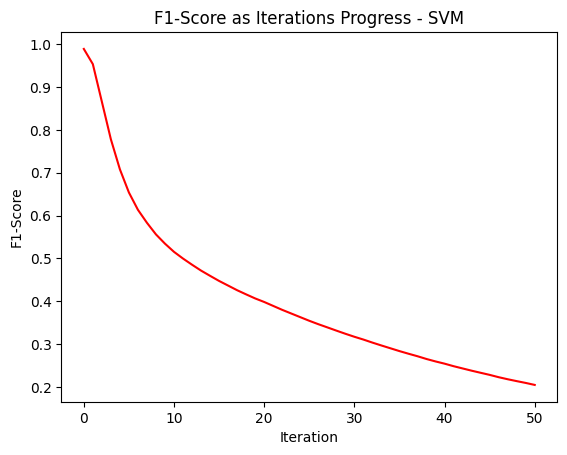

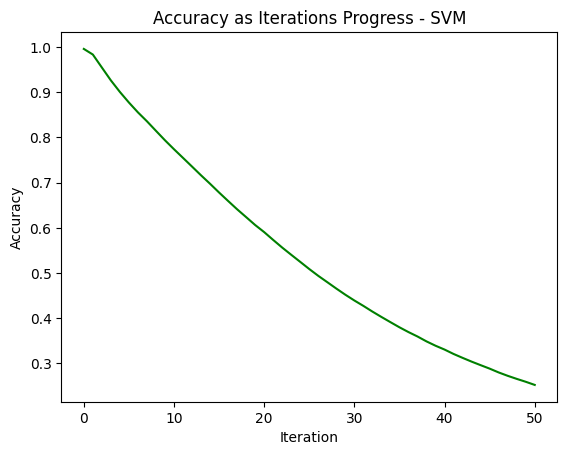

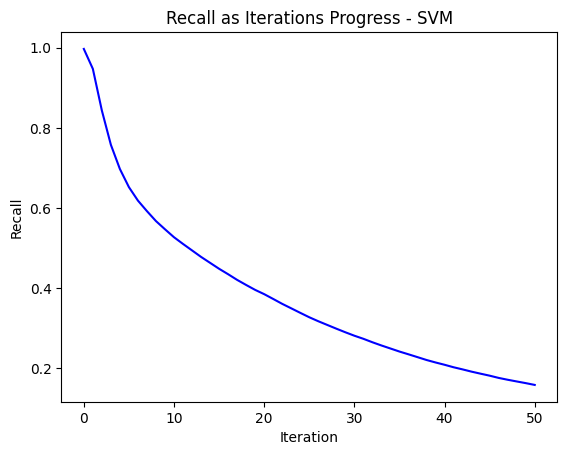

In [19]:
##SVM
model_names= 'SVM'
# Instantiate the callbacks
metric_callback_svc = MetricCallback(model_svc, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_svc = TimeCallback(verbose=2)
custom_callback_svc = MyCustomCallback()

# Configure the callbacks list
callbacks_svc = [metric_callback_svc, time_callback_svc, custom_callback_svc]

# Generate adversarial samples with callbacks
X_adversarial_svc = a2pm_classifier.fit_generate(model_svc, x_train, y_train, iterations=50, patience=2, callback = callbacks_svc)


# Plot the scores
metric_callback_svc.plot_scores()

In [20]:
f1_scores = [round(score, 3) for score in metric_callback_svc.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_svc.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_svc.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.989, 0.953, 0.866, 0.778, 0.708, 0.654, 0.613, 0.583, 0.556, 0.534, 0.515, 0.5, 0.485, 0.472, 0.459, 0.447, 0.437, 0.426, 0.416, 0.407, 0.398, 0.389, 0.38, 0.371, 0.363, 0.354, 0.347, 0.339, 0.332, 0.324, 0.317, 0.311, 0.304, 0.297, 0.29, 0.284, 0.278, 0.272, 0.265, 0.26, 0.254, 0.249, 0.243, 0.238, 0.233, 0.228, 0.223, 0.218, 0.214, 0.209, 0.205]
Max F1-Score: 0.989
Min F1-Score: 0.205

==================Accuracy Scores====================
Accuracy Scores: [0.996, 0.983, 0.955, 0.926, 0.901, 0.877, 0.855, 0.836, 0.815, 0.794, 0.774, 0.755, 0.735, 0.716, 0.697, 0.678, 0.659, 0.641, 0.624, 0.606, 0.59, 0.573, 0.556, 0.54, 0.525, 0.509, 0.494, 0.48, 0.466, 0.452, 0.439, 0.427, 0.415, 0.403, 0.391, 0.38, 0.369, 0.359, 0.349, 0.339, 0.331, 0.321, 0.312, 0.304, 0.296, 0.288, 0.28, 0.272, 0.266, 0.259, 0.252]
Max Accuracy: 0.996
Min Accuracy: 0.252

==================Recall Scores====================
Recall Scores: [0.997, 0.947, 

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 1.49 sec
Custom callback called
Iteration: 2, Time: 1.30 sec
Custom callback called
Iteration: 3, Time: 1.20 sec
Custom callback called
Iteration: 4, Time: 1.12 sec
Custom callback called
Iteration: 5, Time: 1.07 sec
Custom callback called
Iteration: 6, Time: 1.01 sec
Custom callback called
Iteration: 7, Time: 0.97 sec
Custom callback called
Iteration: 8, Time: 0.94 sec
Custom callback called
Iteration: 9, Time: 0.91 sec
Custom callback called
Iteration: 10, Time: 0.88 sec
Custom callback called
Iteration: 11, Time: 0.85 sec
Custom callback called
Iteration: 12, Time: 0.84 sec
Custom callback called
Iteration: 13, Time: 0.81 sec
Custom callback called
Iteration: 14, Time: 0.80 sec
Custom callback called
Iteration: 15, Time: 0.79 sec
Custom callback called
Iteration: 16, Time: 0.76 sec
Custom callback called
Iteration: 17, Time: 0.73 sec
Custom callback called
Iteration: 18, Time: 0.72 sec
Custom callback called
Ite

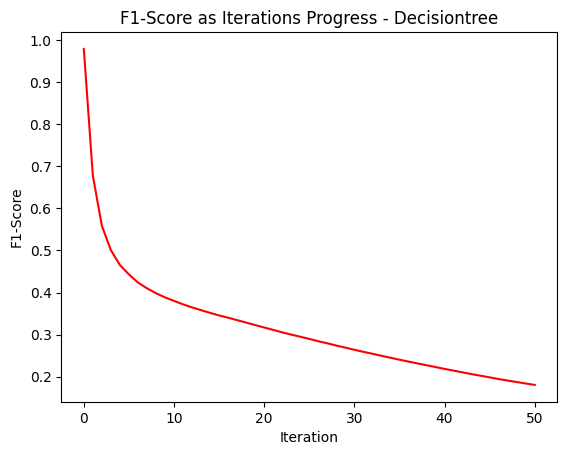

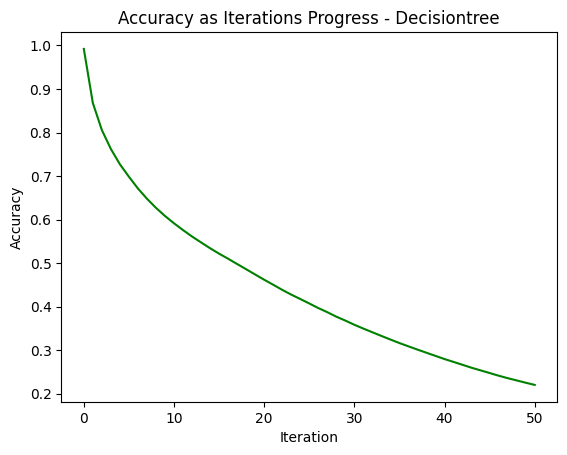

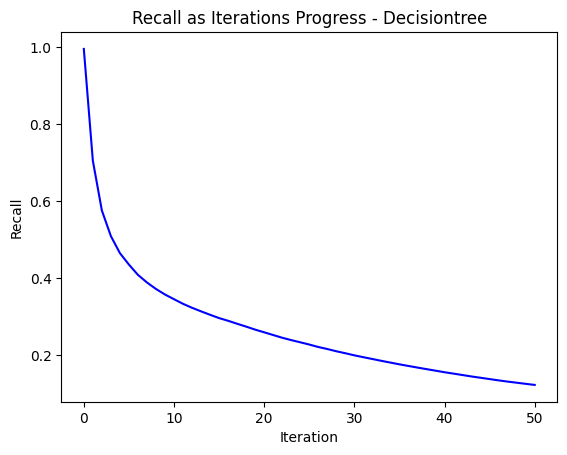

In [21]:
##Decisiontree
model_names= 'Decisiontree'
# Instantiate the callbacks
metric_callback_dt = MetricCallback(model_dt, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_dt = TimeCallback(verbose=2)
custom_callback_dt = MyCustomCallback()

# Configure the callbacks list
callbacks_dt = [metric_callback_dt, time_callback_dt, custom_callback_dt]

# Generate adversarial samples with callbacks
X_adversarial_dt = a2pm_classifier.fit_generate(model_dt, x_train, y_train, iterations=50, patience=2, callback = callbacks_dt)


# Plot the scores
metric_callback_dt.plot_scores()

In [22]:
f1_scores = [round(score, 3) for score in metric_callback_dt.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_dt.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_dt.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.979, 0.678, 0.559, 0.501, 0.465, 0.443, 0.424, 0.41, 0.398, 0.388, 0.38, 0.372, 0.365, 0.358, 0.352, 0.346, 0.34, 0.334, 0.329, 0.323, 0.317, 0.311, 0.305, 0.3, 0.295, 0.29, 0.284, 0.279, 0.274, 0.269, 0.264, 0.259, 0.254, 0.25, 0.245, 0.24, 0.236, 0.232, 0.227, 0.223, 0.219, 0.214, 0.21, 0.206, 0.202, 0.198, 0.194, 0.191, 0.187, 0.184, 0.18]
Max F1-Score: 0.979
Min F1-Score: 0.18

==================Accuracy Scores====================
Accuracy Scores: [0.992, 0.868, 0.806, 0.762, 0.727, 0.699, 0.671, 0.648, 0.627, 0.608, 0.592, 0.576, 0.561, 0.548, 0.534, 0.522, 0.51, 0.498, 0.486, 0.474, 0.462, 0.45, 0.439, 0.428, 0.418, 0.407, 0.397, 0.387, 0.377, 0.368, 0.358, 0.35, 0.341, 0.333, 0.324, 0.316, 0.309, 0.301, 0.294, 0.287, 0.28, 0.273, 0.266, 0.26, 0.254, 0.247, 0.241, 0.236, 0.23, 0.225, 0.22]
Max Accuracy: 0.992
Min Accuracy: 0.22

==================Recall Scores====================
Recall Scores: [0.995, 0.705, 0.576, 0.

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 1.50 sec
Custom callback called
Iteration: 2, Time: 1.45 sec
Custom callback called
Iteration: 3, Time: 1.40 sec
Custom callback called
Iteration: 4, Time: 1.34 sec
Custom callback called
Iteration: 5, Time: 1.34 sec
Custom callback called
Iteration: 6, Time: 1.31 sec
Custom callback called
Iteration: 7, Time: 1.31 sec
Custom callback called
Iteration: 8, Time: 1.30 sec
Custom callback called
Iteration: 9, Time: 1.31 sec
Custom callback called
Iteration: 10, Time: 1.26 sec
Custom callback called
Iteration: 11, Time: 1.26 sec
Custom callback called
Iteration: 12, Time: 1.24 sec
Custom callback called
Iteration: 13, Time: 1.23 sec
Custom callback called
Iteration: 14, Time: 1.21 sec
Custom callback called
Iteration: 15, Time: 1.22 sec
Custom callback called
Iteration: 16, Time: 1.18 sec
Custom callback called
Iteration: 17, Time: 1.19 sec
Custom callback called
Iteration: 18, Time: 1.17 sec
Custom callback called
Ite

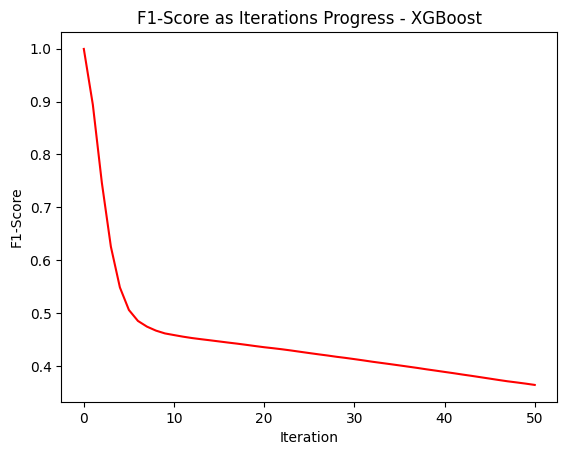

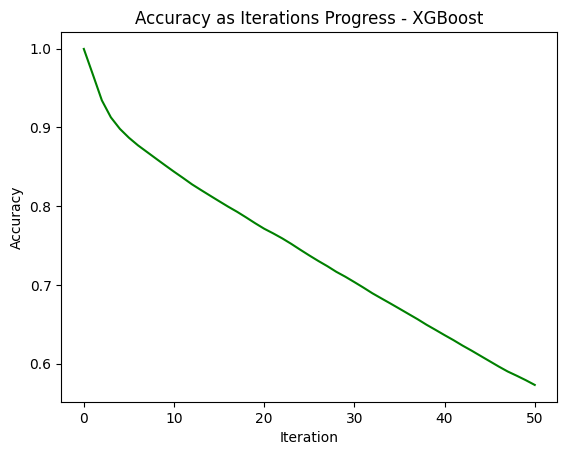

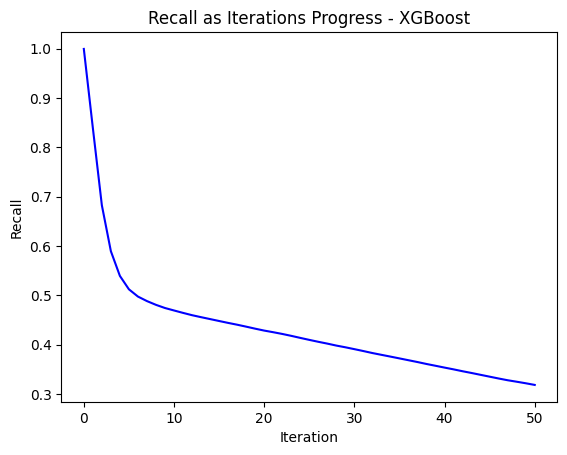

In [23]:
##XGBoost
model_names= 'XGBoost'
# Instantiate the callbacks
metric_callback_xgb = MetricCallback(model_xgb, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_xgb = TimeCallback(verbose=2)
custom_callback_xgb = MyCustomCallback()

# Configure the callbacks list
callbacks_xgb = [metric_callback_xgb, time_callback_xgb, custom_callback_xgb]

# Generate adversarial samples with callbacks
X_adversarial_xgb = a2pm_classifier.fit_generate(model_xgb, x_train, y_train, iterations=50, patience=2, callback = callbacks_xgb)


# Plot the scores
metric_callback_xgb.plot_scores()

In [24]:
f1_scores = [round(score, 3) for score in metric_callback_xgb.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_xgb.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_xgb.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.999, 0.894, 0.746, 0.626, 0.549, 0.506, 0.485, 0.474, 0.467, 0.462, 0.459, 0.455, 0.453, 0.451, 0.449, 0.446, 0.444, 0.442, 0.44, 0.438, 0.436, 0.434, 0.432, 0.429, 0.427, 0.424, 0.422, 0.42, 0.418, 0.415, 0.413, 0.411, 0.408, 0.406, 0.404, 0.401, 0.399, 0.396, 0.394, 0.391, 0.389, 0.386, 0.384, 0.381, 0.379, 0.376, 0.374, 0.371, 0.369, 0.367, 0.364]
Max F1-Score: 0.999
Min F1-Score: 0.364

==================Accuracy Scores====================
Accuracy Scores: [1.0, 0.967, 0.934, 0.913, 0.898, 0.887, 0.877, 0.869, 0.86, 0.852, 0.844, 0.836, 0.828, 0.82, 0.813, 0.806, 0.799, 0.793, 0.786, 0.778, 0.771, 0.765, 0.759, 0.752, 0.745, 0.737, 0.73, 0.724, 0.717, 0.71, 0.704, 0.697, 0.689, 0.683, 0.676, 0.67, 0.663, 0.656, 0.649, 0.643, 0.636, 0.63, 0.623, 0.616, 0.61, 0.603, 0.596, 0.59, 0.585, 0.579, 0.573]
Max Accuracy: 1.0
Min Accuracy: 0.573

==================Recall Scores====================
Recall Scores: [1.0, 0.84, 0.683, 

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 1.48 sec
Custom callback called
Iteration: 2, Time: 1.39 sec
Custom callback called
Iteration: 3, Time: 1.35 sec
Custom callback called
Iteration: 4, Time: 1.31 sec
Custom callback called
Iteration: 5, Time: 1.26 sec
Custom callback called
Iteration: 6, Time: 1.24 sec
Custom callback called
Iteration: 7, Time: 1.21 sec
Custom callback called
Iteration: 8, Time: 1.19 sec
Custom callback called
Iteration: 9, Time: 1.17 sec
Custom callback called
Iteration: 10, Time: 1.14 sec
Custom callback called
Iteration: 11, Time: 1.13 sec
Custom callback called
Iteration: 12, Time: 1.14 sec
Custom callback called
Iteration: 13, Time: 1.11 sec
Custom callback called
Iteration: 14, Time: 1.10 sec
Custom callback called
Iteration: 15, Time: 1.09 sec
Custom callback called
Iteration: 16, Time: 1.07 sec
Custom callback called
Iteration: 17, Time: 1.07 sec
Custom callback called
Iteration: 18, Time: 1.07 sec
Custom callback called
Ite

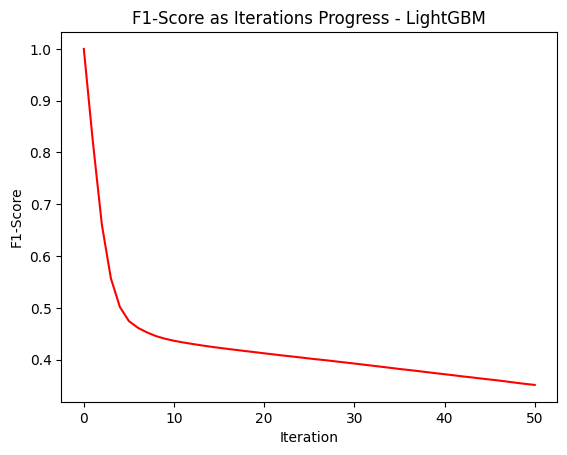

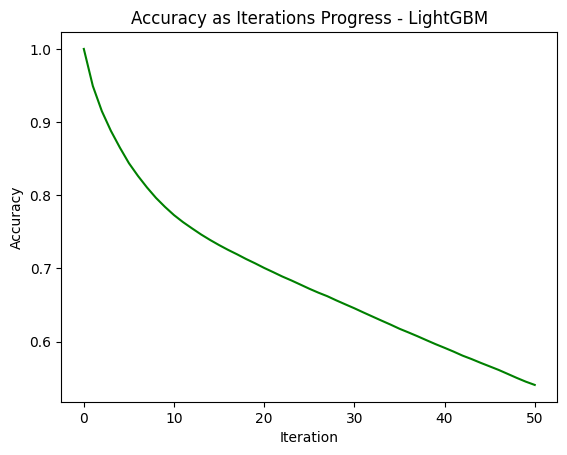

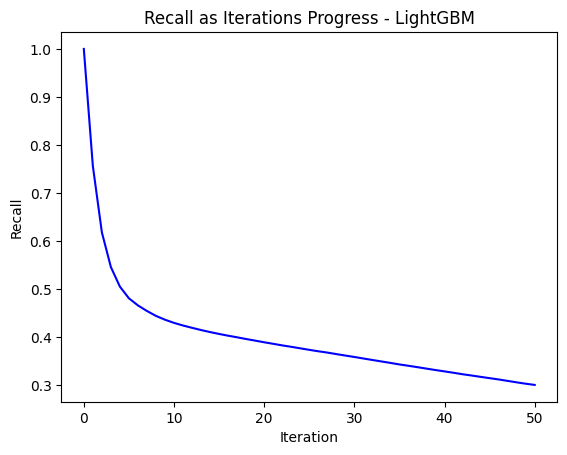

In [25]:
##LightGBM
model_names= 'LightGBM'
# Instantiate the callbacks
metric_callback_lgbm = MetricCallback(model_lgbm, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_lgbm = TimeCallback(verbose=2)
custom_callback_lgbm = MyCustomCallback()

# Configure the callbacks list
callbacks_lgbm = [metric_callback_lgbm, time_callback_lgbm, custom_callback_lgbm]

# Generate adversarial samples with callbacks
X_adversarial_lgbm = a2pm_classifier.fit_generate(model_lgbm, x_train, y_train, iterations=50, patience=2, callback = callbacks_lgbm)


# Plot the scores
metric_callback_lgbm.plot_scores()

In [26]:
f1_scores = [round(score, 3) for score in metric_callback_lgbm.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_lgbm.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_lgbm.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [1.0, 0.821, 0.661, 0.557, 0.502, 0.474, 0.461, 0.453, 0.445, 0.44, 0.436, 0.433, 0.43, 0.428, 0.425, 0.423, 0.421, 0.418, 0.416, 0.414, 0.412, 0.41, 0.408, 0.406, 0.404, 0.402, 0.4, 0.398, 0.396, 0.394, 0.392, 0.39, 0.388, 0.386, 0.384, 0.382, 0.38, 0.378, 0.376, 0.374, 0.372, 0.37, 0.368, 0.366, 0.364, 0.362, 0.36, 0.357, 0.355, 0.353, 0.351]
Max F1-Score: 1.0
Min F1-Score: 0.351

==================Accuracy Scores====================
Accuracy Scores: [1.0, 0.949, 0.915, 0.888, 0.865, 0.844, 0.826, 0.811, 0.796, 0.784, 0.773, 0.763, 0.755, 0.746, 0.739, 0.732, 0.725, 0.719, 0.713, 0.707, 0.701, 0.695, 0.689, 0.684, 0.678, 0.672, 0.667, 0.662, 0.656, 0.651, 0.646, 0.64, 0.634, 0.629, 0.623, 0.618, 0.613, 0.607, 0.602, 0.597, 0.592, 0.586, 0.581, 0.576, 0.571, 0.566, 0.561, 0.556, 0.551, 0.545, 0.541]
Max Accuracy: 1.0
Min Accuracy: 0.541

==================Recall Scores====================
Recall Scores: [1.0, 0.756, 0.618, 0.5

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 2.41 sec
Custom callback called
Iteration: 2, Time: 2.19 sec
Custom callback called
Iteration: 3, Time: 2.13 sec
Custom callback called
Iteration: 4, Time: 1.99 sec
Custom callback called
Iteration: 5, Time: 1.92 sec
Custom callback called
Iteration: 6, Time: 1.84 sec
Custom callback called
Iteration: 7, Time: 1.76 sec
Custom callback called
Iteration: 8, Time: 1.74 sec
Custom callback called
Iteration: 9, Time: 1.68 sec
Custom callback called
Iteration: 10, Time: 1.61 sec
Custom callback called
Iteration: 11, Time: 1.56 sec
Custom callback called
Iteration: 12, Time: 1.57 sec
Custom callback called
Iteration: 13, Time: 1.55 sec
Custom callback called
Iteration: 14, Time: 1.42 sec
Custom callback called
Iteration: 15, Time: 1.41 sec
Custom callback called
Iteration: 16, Time: 1.38 sec
Custom callback called
Iteration: 17, Time: 1.37 sec
Custom callback called
Iteration: 18, Time: 1.40 sec
Custom callback called
Ite

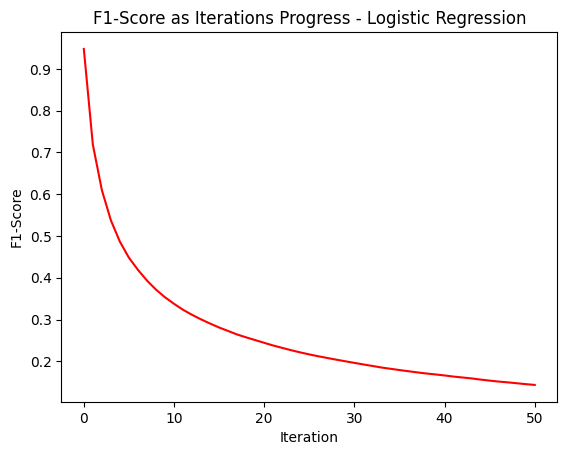

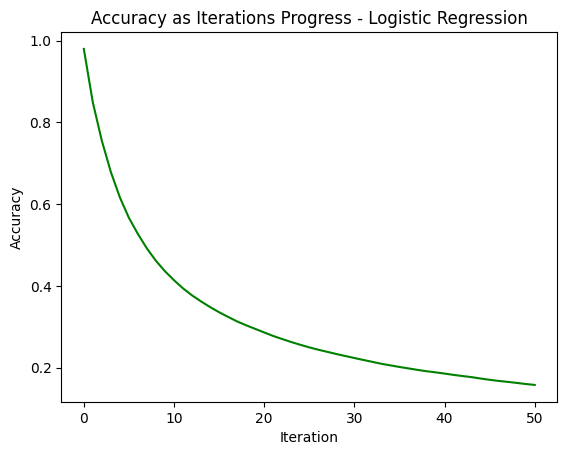

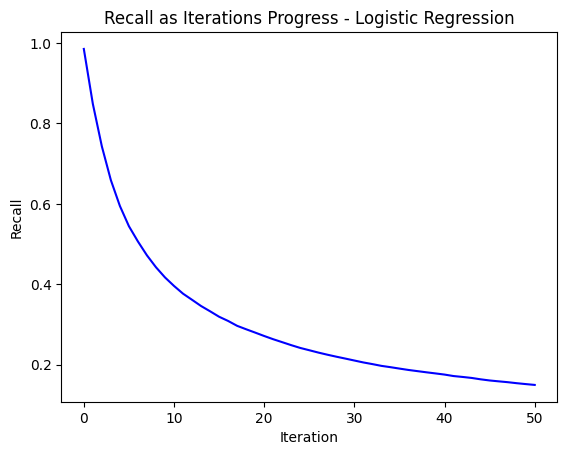

In [27]:
##Logistic Regression
model_names= 'Logistic Regression'
# Instantiate the callbacks
metric_callback_lg = MetricCallback(model_lg, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_lg = TimeCallback(verbose=2)
custom_callback_lg = MyCustomCallback()

# Configure the callbacks list
callbacks_lg = [metric_callback_lg, time_callback_lg, custom_callback_lg]

# Generate adversarial samples with callbacks
X_adversarial_lg = a2pm_classifier.fit_generate(model_lg, x_train, y_train, iterations=50, patience=2, callback = callbacks_lg)


# Plot the scores
metric_callback_lg.plot_scores()

In [28]:
f1_scores = [round(score, 3) for score in metric_callback_lg.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_lg.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_lg.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.948, 0.719, 0.61, 0.537, 0.486, 0.448, 0.419, 0.393, 0.372, 0.353, 0.338, 0.323, 0.311, 0.3, 0.29, 0.281, 0.273, 0.264, 0.257, 0.251, 0.244, 0.238, 0.232, 0.226, 0.221, 0.216, 0.212, 0.208, 0.204, 0.2, 0.196, 0.192, 0.189, 0.185, 0.182, 0.179, 0.176, 0.173, 0.171, 0.168, 0.166, 0.163, 0.161, 0.159, 0.156, 0.154, 0.151, 0.15, 0.147, 0.145, 0.143]
Max F1-Score: 0.948
Min F1-Score: 0.143

==================Accuracy Scores====================
Accuracy Scores: [0.98, 0.849, 0.755, 0.678, 0.616, 0.567, 0.527, 0.492, 0.461, 0.436, 0.414, 0.394, 0.377, 0.362, 0.348, 0.336, 0.324, 0.313, 0.304, 0.295, 0.286, 0.278, 0.27, 0.263, 0.256, 0.25, 0.244, 0.239, 0.233, 0.229, 0.224, 0.219, 0.214, 0.21, 0.206, 0.202, 0.198, 0.195, 0.191, 0.189, 0.186, 0.182, 0.18, 0.177, 0.174, 0.17, 0.168, 0.165, 0.163, 0.16, 0.158]
Max Accuracy: 0.98
Min Accuracy: 0.158

==================Recall Scores====================
Recall Scores: [0.985, 0.849, 0.743

#Targeted attack against a classifier

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 0.14 sec
Custom callback called
Iteration: 2, Time: 0.06 sec
Custom callback called
Iteration: 3, Time: 0.03 sec
Custom callback called
Iteration: 4, Time: 0.01 sec
Custom callback called
Iteration: 5, Time: 0.01 sec
Custom callback called
Iteration: 6, Time: 0.00 sec
Custom callback called
Iteration: 7, Time: 0.00 sec
Custom callback called
Iteration: 8, Time: 0.00 sec
Custom callback called
Iteration: 9, Time: 0.00 sec
Custom callback called
Iteration: 10, Time: 0.00 sec
Custom callback called
Iteration: 11, Time: 0.00 sec
Custom callback called
Iteration: 12, Time: 0.00 sec
Custom callback called
Iteration: 13, Time: 0.00 sec
Custom callback called
Iteration: 14, Time: 0.00 sec
Custom callback called
Iteration: 15, Time: 0.00 sec
Custom callback called


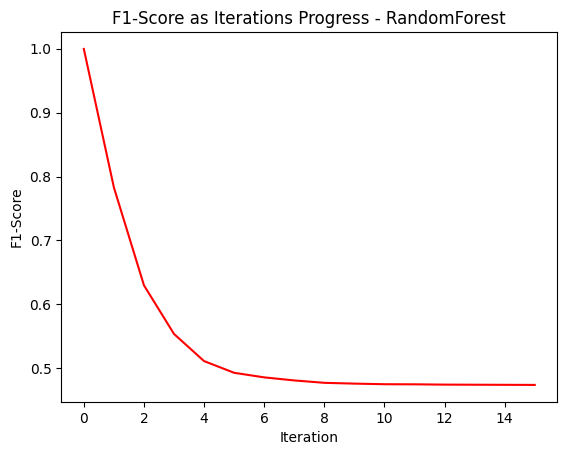

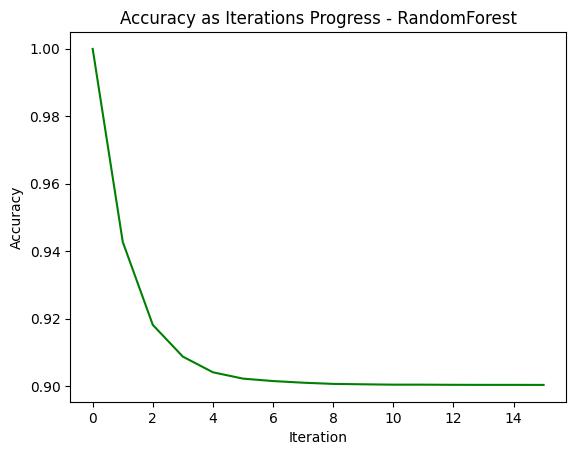

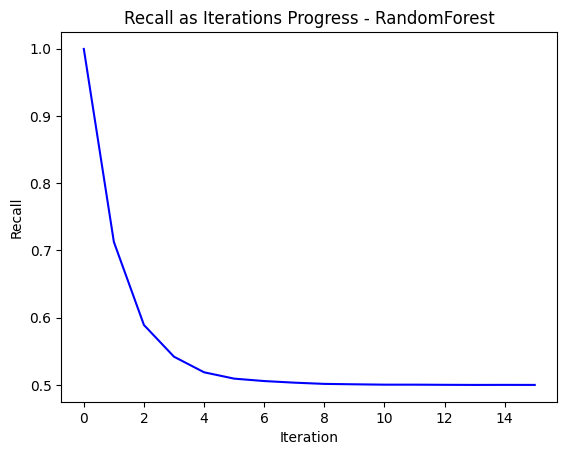

In [29]:
##RandomForest
model_names= 'RandomForest'
# Instantiate the callbacks
metric_callback_rf = MetricCallback(model_rf, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_rf = TimeCallback(verbose=2)
custom_callback_rf = MyCustomCallback()

# Configure the callbacks list
callbacks_rf = [metric_callback_rf, time_callback_rf, custom_callback_rf]

# Generate adversarial samples with callbacks
X_adversarial_rf = a2pm_classifier.fit_generate(model_rf, x_train, y_train, y_target,iterations=50, patience=2, callback = callbacks_rf)

# Plot the scores
metric_callback_rf.plot_scores()

In [30]:
f1_scores = [round(score, 3) for score in metric_callback_rf.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_rf.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_rf.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [1.0, 0.783, 0.63, 0.554, 0.511, 0.493, 0.486, 0.481, 0.477, 0.476, 0.475, 0.475, 0.474, 0.474, 0.474, 0.474]
Max F1-Score: 1.0
Min F1-Score: 0.474

==================Accuracy Scores====================
Accuracy Scores: [1.0, 0.943, 0.918, 0.909, 0.904, 0.902, 0.902, 0.901, 0.901, 0.901, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
Max Accuracy: 1.0
Min Accuracy: 0.9

==================Recall Scores====================
Recall Scores: [1.0, 0.713, 0.589, 0.542, 0.519, 0.509, 0.506, 0.503, 0.502, 0.501, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Max Recall: 1.0
Min Recall: 0.5


Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 0.15 sec
Custom callback called
Iteration: 2, Time: 0.12 sec
Custom callback called
Iteration: 3, Time: 0.07 sec
Custom callback called
Iteration: 4, Time: 0.04 sec
Custom callback called
Iteration: 5, Time: 0.02 sec
Custom callback called
Iteration: 6, Time: 0.01 sec
Custom callback called
Iteration: 7, Time: 0.01 sec
Custom callback called
Iteration: 8, Time: 0.00 sec
Custom callback called
Iteration: 9, Time: 0.00 sec
Custom callback called
Iteration: 10, Time: 0.00 sec
Custom callback called
Iteration: 11, Time: 0.00 sec
Custom callback called
Iteration: 12, Time: 0.00 sec
Custom callback called
Iteration: 13, Time: 0.00 sec
Custom callback called
Iteration: 14, Time: 0.00 sec
Custom callback called
Iteration: 15, Time: 0.00 sec
Custom callback called
Iteration: 16, Time: 0.00 sec
Custom callback called
Iteration: 17, Time: 0.00 sec
Custom callback called
Iteration: 18, Time: 0.00 sec
Custom callback called


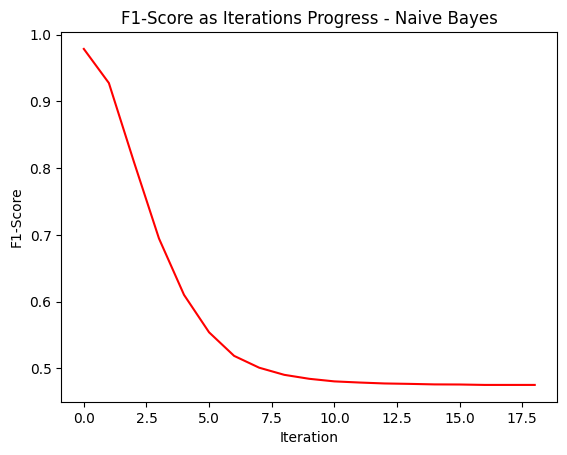

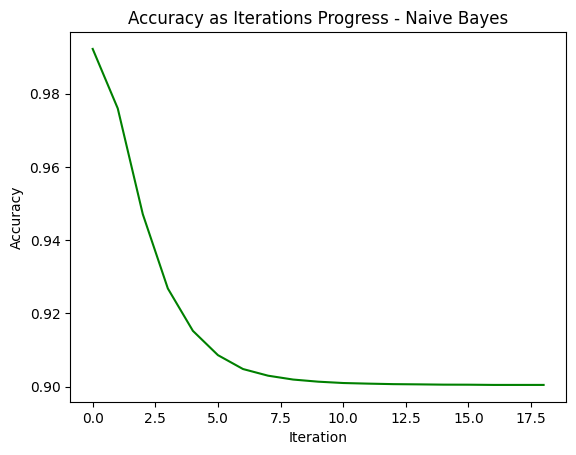

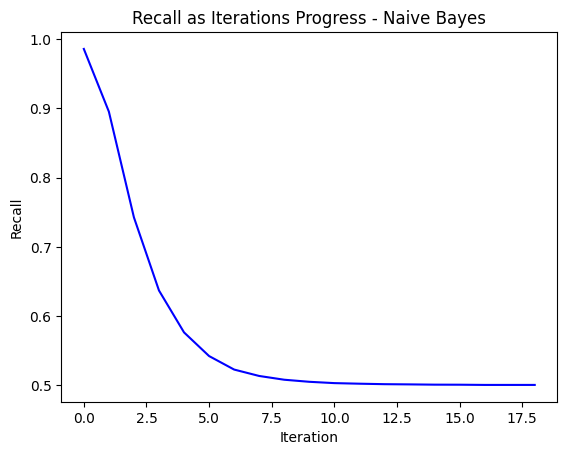

In [31]:
##Naive Bayes
model_names= 'Naive Bayes'
# Instantiate the callbacks
metric_callback_nb = MetricCallback(model_nb, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_nb = TimeCallback(verbose=2)
custom_callback_nb = MyCustomCallback()

# Configure the callbacks list
callbacks_nb = [metric_callback_nb, time_callback_nb, custom_callback_nb]

# Generate adversarial samples with callbacks
X_adversarial_nb = a2pm_classifier.fit_generate(model_nb, x_train, y_train, y_target,iterations=50, patience=2, callback = callbacks_nb)


# Plot the scores
metric_callback_nb.plot_scores()

In [32]:
f1_scores = [round(score, 3) for score in metric_callback_nb.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_nb.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_nb.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.979, 0.928, 0.809, 0.695, 0.61, 0.554, 0.519, 0.501, 0.49, 0.484, 0.48, 0.479, 0.477, 0.477, 0.476, 0.476, 0.475, 0.475, 0.475]
Max F1-Score: 0.979
Min F1-Score: 0.475

==================Accuracy Scores====================
Accuracy Scores: [0.992, 0.976, 0.947, 0.927, 0.915, 0.909, 0.905, 0.903, 0.902, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.9, 0.9, 0.9]
Max Accuracy: 0.992
Min Accuracy: 0.9

==================Recall Scores====================
Recall Scores: [0.986, 0.895, 0.743, 0.637, 0.576, 0.542, 0.523, 0.514, 0.508, 0.505, 0.503, 0.502, 0.502, 0.501, 0.501, 0.501, 0.501, 0.501, 0.501]
Max Recall: 0.986
Min Recall: 0.501


Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 0.15 sec
Custom callback called
Iteration: 2, Time: 0.14 sec
Custom callback called
Iteration: 3, Time: 0.10 sec
Custom callback called
Iteration: 4, Time: 0.08 sec
Custom callback called
Iteration: 5, Time: 0.07 sec
Custom callback called
Iteration: 6, Time: 0.06 sec
Custom callback called
Iteration: 7, Time: 0.05 sec
Custom callback called
Iteration: 8, Time: 0.04 sec
Custom callback called
Iteration: 9, Time: 0.04 sec
Custom callback called
Iteration: 10, Time: 0.04 sec
Custom callback called
Iteration: 11, Time: 0.03 sec
Custom callback called
Iteration: 12, Time: 0.03 sec
Custom callback called
Iteration: 13, Time: 0.03 sec
Custom callback called
Iteration: 14, Time: 0.03 sec
Custom callback called
Iteration: 15, Time: 0.03 sec
Custom callback called
Iteration: 16, Time: 0.02 sec
Custom callback called
Iteration: 17, Time: 0.02 sec
Custom callback called
Iteration: 18, Time: 0.02 sec
Custom callback called
Ite

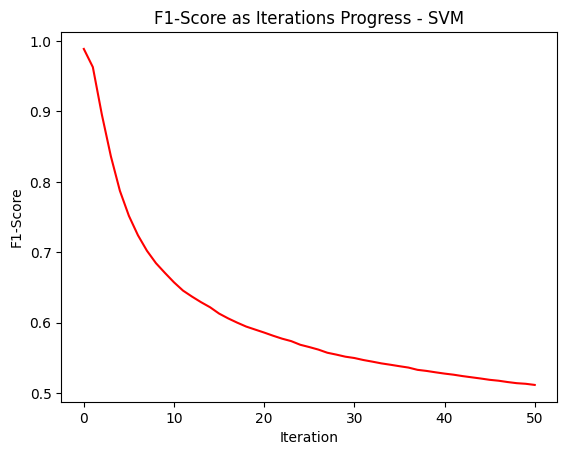

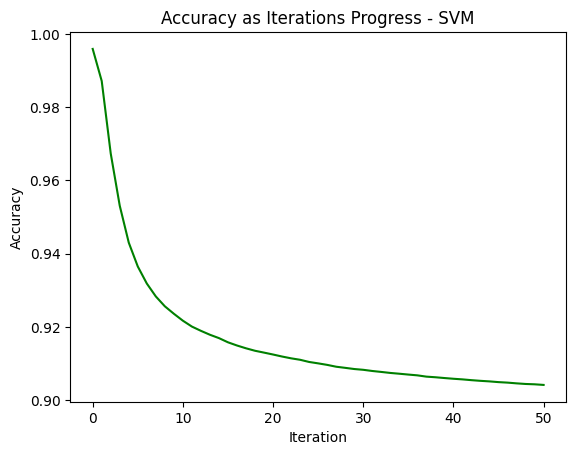

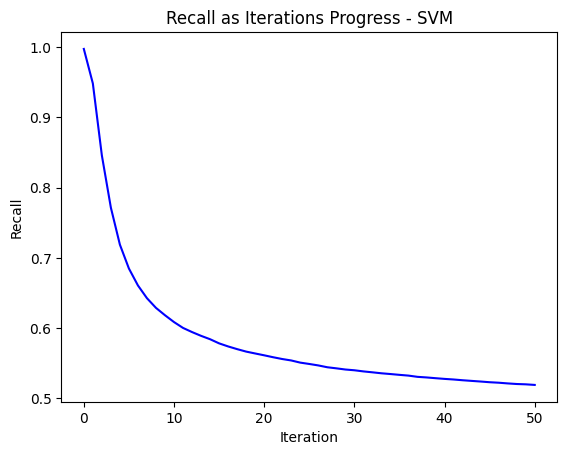

In [43]:
##SVC
model_names= 'SVM'
# Instantiate the callbacks
metric_callback_svc = MetricCallback(model_svc, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_svc = TimeCallback(verbose=2)
custom_callback_svc = MyCustomCallback()

# Configure the callbacks list
callbacks_svc = [metric_callback_svc, time_callback_svc, custom_callback_svc]

# Generate adversarial samples with callbacks
X_adversarial_svc = a2pm_classifier.fit_generate(model_svc, x_train, y_train, y_target,iterations=50, patience=2, callback = callbacks_svc)


# Plot the scores
metric_callback_svc.plot_scores()

In [44]:
f1_scores = [round(score, 3) for score in metric_callback_svc.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_svc.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_svc.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.989, 0.963, 0.896, 0.836, 0.787, 0.752, 0.724, 0.702, 0.685, 0.671, 0.657, 0.646, 0.637, 0.629, 0.622, 0.613, 0.606, 0.6, 0.595, 0.59, 0.586, 0.582, 0.577, 0.574, 0.569, 0.566, 0.562, 0.557, 0.555, 0.552, 0.55, 0.547, 0.545, 0.542, 0.54, 0.538, 0.536, 0.533, 0.532, 0.53, 0.528, 0.526, 0.524, 0.523, 0.521, 0.519, 0.518, 0.516, 0.514, 0.513, 0.512]
Max F1-Score: 0.989
Min F1-Score: 0.512

==================Accuracy Scores====================
Accuracy Scores: [0.996, 0.987, 0.967, 0.953, 0.943, 0.937, 0.932, 0.928, 0.926, 0.924, 0.922, 0.92, 0.919, 0.918, 0.917, 0.916, 0.915, 0.914, 0.914, 0.913, 0.912, 0.912, 0.911, 0.911, 0.91, 0.91, 0.91, 0.909, 0.909, 0.909, 0.908, 0.908, 0.908, 0.907, 0.907, 0.907, 0.907, 0.906, 0.906, 0.906, 0.906, 0.906, 0.905, 0.905, 0.905, 0.905, 0.905, 0.905, 0.904, 0.904, 0.904]
Max Accuracy: 0.996
Min Accuracy: 0.904

==================Recall Scores====================
Recall Scores: [0.997, 0.948, 

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 0.16 sec
Custom callback called
Iteration: 2, Time: 0.08 sec
Custom callback called
Iteration: 3, Time: 0.05 sec
Custom callback called
Iteration: 4, Time: 0.03 sec
Custom callback called
Iteration: 5, Time: 0.02 sec
Custom callback called
Iteration: 6, Time: 0.02 sec
Custom callback called
Iteration: 7, Time: 0.01 sec
Custom callback called
Iteration: 8, Time: 0.01 sec
Custom callback called
Iteration: 9, Time: 0.01 sec
Custom callback called
Iteration: 10, Time: 0.01 sec
Custom callback called
Iteration: 11, Time: 0.01 sec
Custom callback called
Iteration: 12, Time: 0.00 sec
Custom callback called
Iteration: 13, Time: 0.00 sec
Custom callback called
Iteration: 14, Time: 0.00 sec
Custom callback called
Iteration: 15, Time: 0.00 sec
Custom callback called
Iteration: 16, Time: 0.00 sec
Custom callback called
Iteration: 17, Time: 0.00 sec
Custom callback called
Iteration: 18, Time: 0.00 sec
Custom callback called
Ite

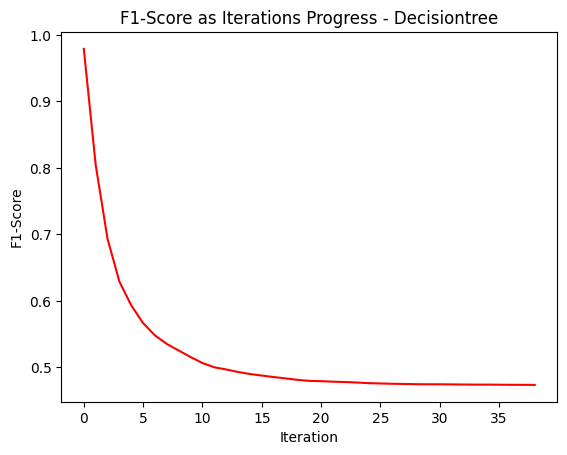

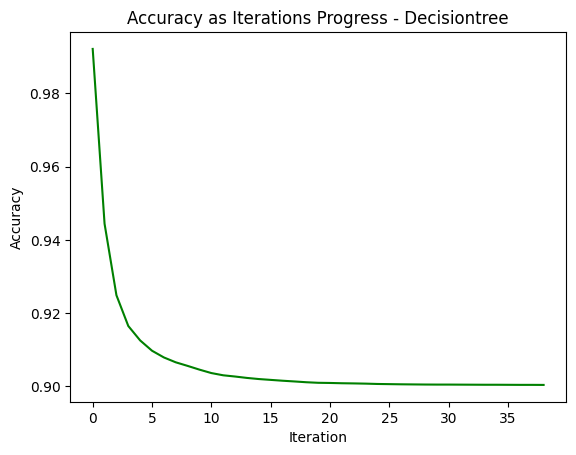

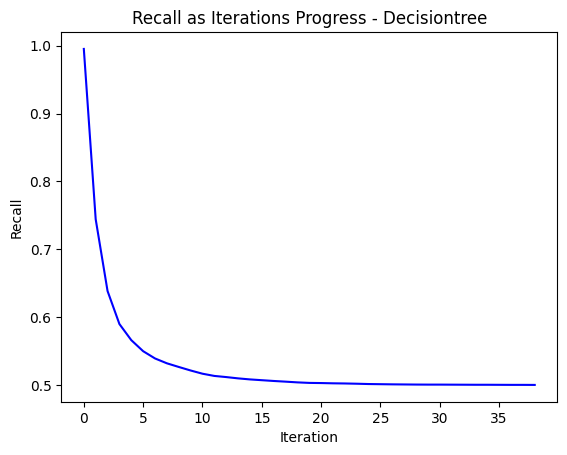

In [35]:
##Decisiontree
model_names= 'Decisiontree'
# Instantiate the callbacks
metric_callback_dt = MetricCallback(model_dt, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_dt = TimeCallback(verbose=2)
custom_callback_dt = MyCustomCallback()

# Configure the callbacks list
callbacks_dt = [metric_callback_dt, time_callback_dt, custom_callback_dt]

# Generate adversarial samples with callbacks
X_adversarial_dt = a2pm_classifier.fit_generate(model_dt, x_train, y_train, y_target,iterations=50, patience=2, callback = callbacks_dt)


# Plot the scores
metric_callback_dt.plot_scores()

In [36]:
f1_scores = [round(score, 3) for score in metric_callback_dt.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_dt.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_dt.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.979, 0.804, 0.693, 0.629, 0.593, 0.567, 0.548, 0.535, 0.525, 0.516, 0.507, 0.5, 0.497, 0.493, 0.49, 0.488, 0.486, 0.484, 0.481, 0.48, 0.479, 0.479, 0.478, 0.477, 0.476, 0.476, 0.476, 0.475, 0.475, 0.475, 0.475, 0.475, 0.474, 0.474, 0.474, 0.474, 0.474, 0.474, 0.474]
Max F1-Score: 0.979
Min F1-Score: 0.474

==================Accuracy Scores====================
Accuracy Scores: [0.992, 0.944, 0.925, 0.916, 0.913, 0.91, 0.908, 0.907, 0.906, 0.905, 0.904, 0.903, 0.903, 0.902, 0.902, 0.902, 0.902, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.901, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
Max Accuracy: 0.992
Min Accuracy: 0.9

==================Recall Scores====================
Recall Scores: [0.995, 0.744, 0.638, 0.59, 0.566, 0.55, 0.539, 0.532, 0.526, 0.521, 0.517, 0.513, 0.512, 0.51, 0.508, 0.507, 0.506, 0.505, 0.504, 0.503, 0.503, 0.502, 0.502, 0.502, 0.501, 0.501, 0.501, 0.501, 0.501, 0

Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 0.15 sec
Custom callback called
Iteration: 2, Time: 0.10 sec
Custom callback called
Iteration: 3, Time: 0.06 sec
Custom callback called
Iteration: 4, Time: 0.03 sec
Custom callback called
Iteration: 5, Time: 0.01 sec
Custom callback called
Iteration: 6, Time: 0.01 sec
Custom callback called
Iteration: 7, Time: 0.00 sec
Custom callback called
Iteration: 8, Time: 0.00 sec
Custom callback called
Iteration: 9, Time: 0.00 sec
Custom callback called
Iteration: 10, Time: 0.00 sec
Custom callback called
Iteration: 11, Time: 0.00 sec
Custom callback called
Iteration: 12, Time: 0.00 sec
Custom callback called
Iteration: 13, Time: 0.00 sec
Custom callback called
Iteration: 14, Time: 0.00 sec
Custom callback called


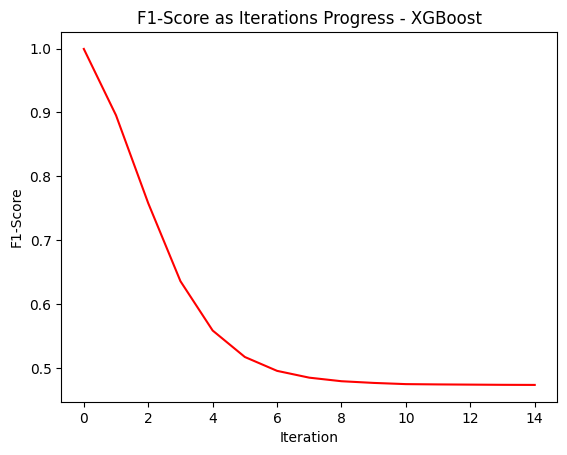

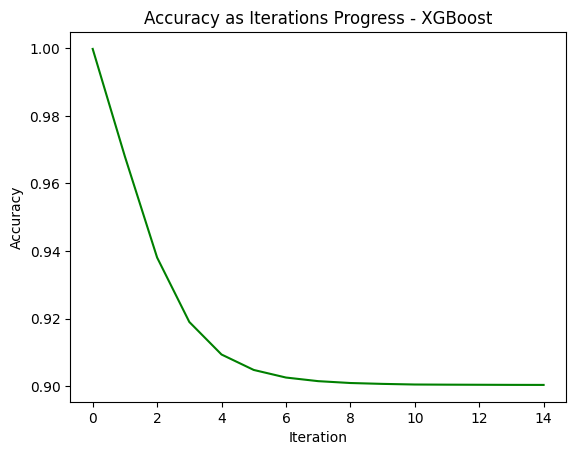

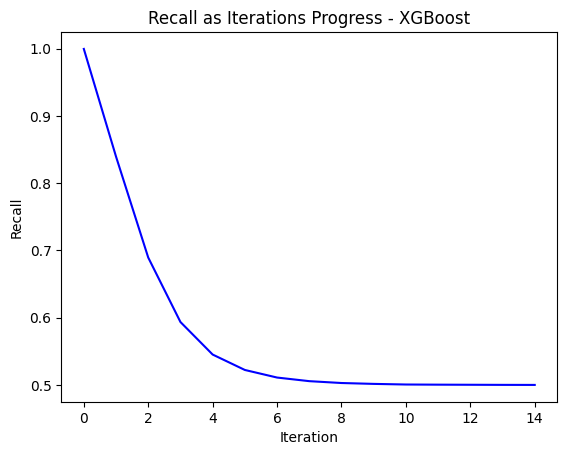

In [37]:
##XGBoost
model_names= 'XGBoost'
# Instantiate the callbacks
metric_callback_xgb = MetricCallback(model_xgb, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_xgb = TimeCallback(verbose=2)
custom_callback_xgb = MyCustomCallback()

# Configure the callbacks list
callbacks_xgb = [metric_callback_xgb, time_callback_xgb, custom_callback_xgb]

# Generate adversarial samples with callbacks
X_adversarial_xgb = a2pm_classifier.fit_generate(model_xgb, x_train, y_train, y_target,iterations=50, patience=2, callback = callbacks_xgb)


# Plot the scores
metric_callback_xgb.plot_scores()

In [38]:
f1_scores = [round(score, 3) for score in metric_callback_xgb.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_xgb.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_xgb.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.999, 0.896, 0.758, 0.636, 0.559, 0.517, 0.496, 0.485, 0.48, 0.477, 0.475, 0.475, 0.474, 0.474, 0.474]
Max F1-Score: 0.999
Min F1-Score: 0.474

==================Accuracy Scores====================
Accuracy Scores: [1.0, 0.968, 0.938, 0.919, 0.909, 0.905, 0.903, 0.901, 0.901, 0.901, 0.9, 0.9, 0.9, 0.9, 0.9]
Max Accuracy: 1.0
Min Accuracy: 0.9

==================Recall Scores====================
Recall Scores: [1.0, 0.84, 0.689, 0.594, 0.545, 0.522, 0.511, 0.506, 0.503, 0.502, 0.501, 0.5, 0.5, 0.5, 0.5]
Max Recall: 1.0
Min Recall: 0.5


Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 0.15 sec
Custom callback called
Iteration: 2, Time: 0.08 sec
Custom callback called
Iteration: 3, Time: 0.04 sec
Custom callback called
Iteration: 4, Time: 0.02 sec
Custom callback called
Iteration: 5, Time: 0.01 sec
Custom callback called
Iteration: 6, Time: 0.00 sec
Custom callback called
Iteration: 7, Time: 0.00 sec
Custom callback called
Iteration: 8, Time: 0.00 sec
Custom callback called
Iteration: 9, Time: 0.00 sec
Custom callback called
Iteration: 10, Time: 0.00 sec
Custom callback called
Iteration: 11, Time: 0.00 sec
Custom callback called
Iteration: 12, Time: 0.00 sec
Custom callback called


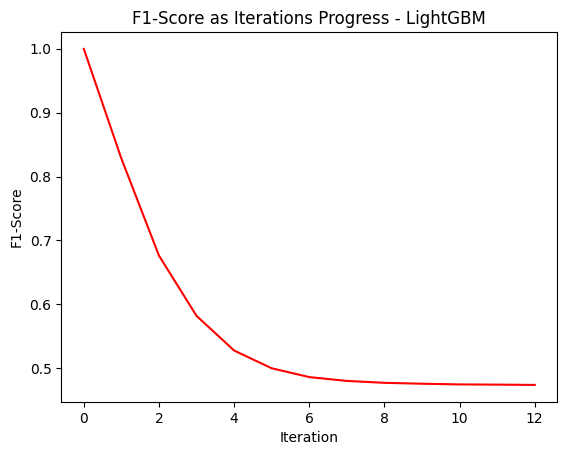

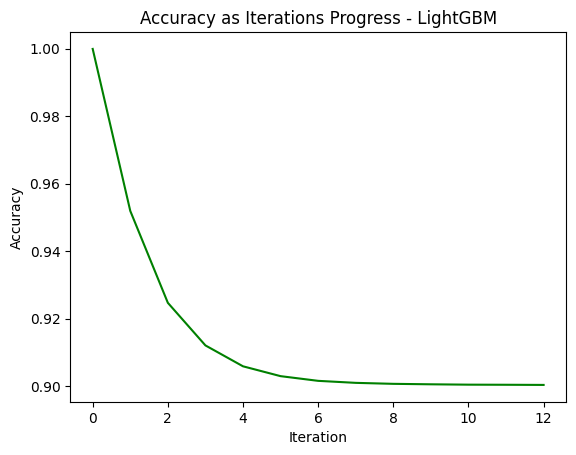

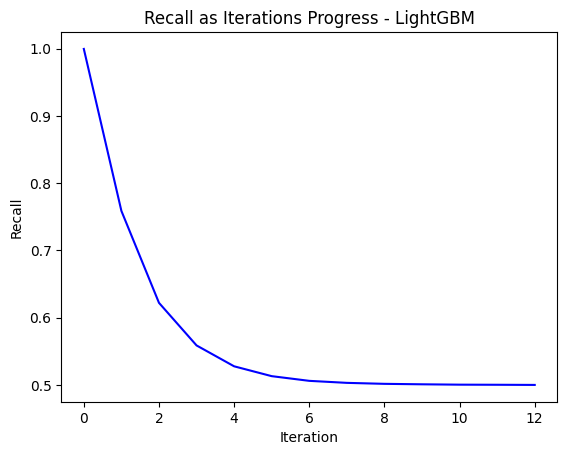

In [39]:
##LightGBM
model_names= 'LightGBM'
# Instantiate the callbacks
metric_callback_lgbm = MetricCallback(model_lgbm, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_lgbm = TimeCallback(verbose=2)
custom_callback_lgbm = MyCustomCallback()

# Configure the callbacks list
callbacks_lgbm = [metric_callback_lgbm, time_callback_lgbm, custom_callback_lgbm]

# Generate adversarial samples with callbacks
X_adversarial_lgbm = a2pm_classifier.fit_generate(model_lgbm, x_train, y_train, y_target,iterations=50, patience=2, callback = callbacks_lgbm)


# Plot the scores
metric_callback_lgbm.plot_scores()

In [40]:
f1_scores = [round(score, 3) for score in metric_callback_lgbm.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_lgbm.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_lgbm.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [1.0, 0.828, 0.676, 0.582, 0.528, 0.5, 0.486, 0.48, 0.477, 0.476, 0.475, 0.474, 0.474]
Max F1-Score: 1.0
Min F1-Score: 0.474

==================Accuracy Scores====================
Accuracy Scores: [1.0, 0.952, 0.925, 0.912, 0.906, 0.903, 0.902, 0.901, 0.901, 0.901, 0.9, 0.9, 0.9]
Max Accuracy: 1.0
Min Accuracy: 0.9

==================Recall Scores====================
Recall Scores: [1.0, 0.759, 0.622, 0.559, 0.528, 0.513, 0.506, 0.503, 0.502, 0.501, 0.5, 0.5, 0.5]
Max Recall: 1.0
Min Recall: 0.5


Iteration: 0, Time: 0.00 sec
Custom callback called
Iteration: 1, Time: 1.15 sec
Custom callback called
Iteration: 2, Time: 1.08 sec
Custom callback called
Iteration: 3, Time: 1.07 sec
Custom callback called
Iteration: 4, Time: 1.06 sec
Custom callback called
Iteration: 5, Time: 1.07 sec
Custom callback called
Iteration: 6, Time: 1.06 sec
Custom callback called
Iteration: 7, Time: 1.03 sec
Custom callback called
Iteration: 8, Time: 1.03 sec
Custom callback called
Iteration: 9, Time: 0.70 sec
Custom callback called
Iteration: 10, Time: 1.02 sec
Custom callback called
Iteration: 11, Time: 1.11 sec
Custom callback called
Iteration: 12, Time: 1.11 sec
Custom callback called
Iteration: 13, Time: 1.10 sec
Custom callback called
Iteration: 14, Time: 1.09 sec
Custom callback called
Iteration: 15, Time: 0.98 sec
Custom callback called
Iteration: 16, Time: 0.98 sec
Custom callback called
Iteration: 17, Time: 0.90 sec
Custom callback called
Iteration: 18, Time: 0.94 sec
Custom callback called
Ite

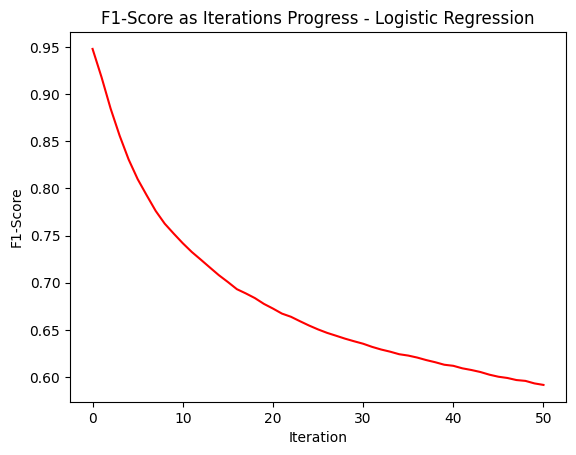

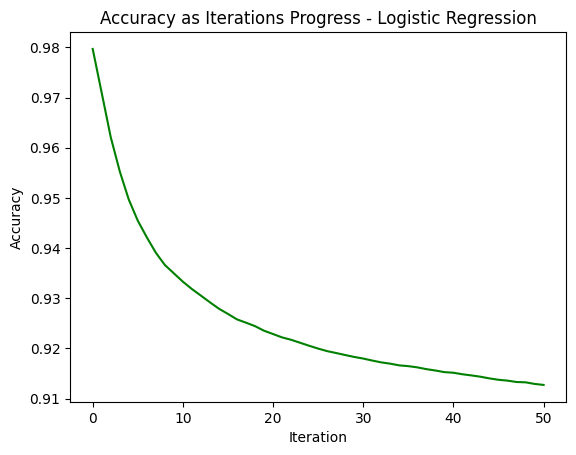

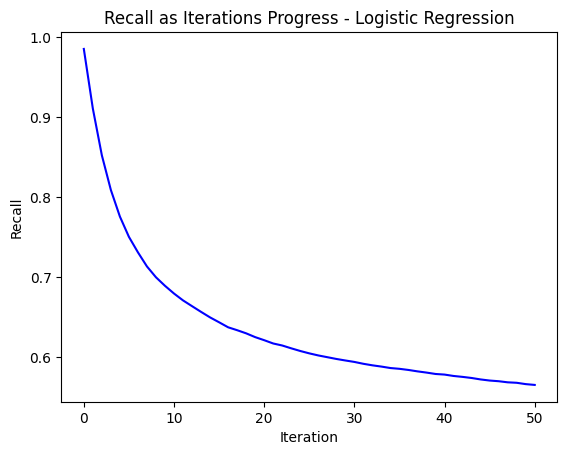

In [41]:
##Logistic Regression
model_names= 'Logistic Regression'
# Instantiate the callbacks
metric_callback_lg = MetricCallback(model_lg, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback_lg = TimeCallback(verbose=2)
custom_callback_lg = MyCustomCallback()

# Configure the callbacks list
callbacks_lg = [metric_callback_lg, time_callback_lg, custom_callback_lg]

# Generate adversarial samples with callbacks
X_adversarial_lg = a2pm_classifier.fit_generate(model_lg, x_train, y_train, y_target,iterations=50, patience=2, callback = callbacks_lg)


# Plot the scores
metric_callback_lg.plot_scores()

In [42]:
f1_scores = [round(score, 3) for score in metric_callback_lg.scores["F1-Score"]]
accuracy_scores = [round(score, 3) for score in metric_callback_lg.scores["Accuracy"]]
recall_scores = [round(score, 3) for score in metric_callback_lg.scores["Recall"]]

print("==================F1-Scores====================")
print("F1-Scores:", f1_scores)
print("Max F1-Score:", max(f1_scores))
print("Min F1-Score:", min(f1_scores))
print()
print("==================Accuracy Scores====================")
print("Accuracy Scores:", accuracy_scores)
print("Max Accuracy:", max(accuracy_scores))
print("Min Accuracy:", min(accuracy_scores))
print()
print("==================Recall Scores====================")
print("Recall Scores:", recall_scores)
print("Max Recall:", max(recall_scores))
print("Min Recall:", min(recall_scores))

==================F1-Scores====================
F1-Scores: [0.948, 0.918, 0.885, 0.856, 0.831, 0.81, 0.793, 0.776, 0.763, 0.752, 0.742, 0.733, 0.724, 0.716, 0.708, 0.701, 0.693, 0.689, 0.684, 0.678, 0.673, 0.667, 0.664, 0.659, 0.655, 0.65, 0.647, 0.644, 0.641, 0.638, 0.635, 0.632, 0.629, 0.627, 0.624, 0.623, 0.621, 0.618, 0.616, 0.613, 0.612, 0.609, 0.607, 0.605, 0.603, 0.6, 0.599, 0.597, 0.596, 0.593, 0.592]
Max F1-Score: 0.948
Min F1-Score: 0.592

==================Accuracy Scores====================
Accuracy Scores: [0.98, 0.971, 0.962, 0.955, 0.95, 0.945, 0.942, 0.939, 0.937, 0.935, 0.933, 0.932, 0.931, 0.929, 0.928, 0.927, 0.926, 0.925, 0.924, 0.924, 0.923, 0.922, 0.922, 0.921, 0.921, 0.92, 0.919, 0.919, 0.919, 0.918, 0.918, 0.918, 0.917, 0.917, 0.917, 0.916, 0.916, 0.916, 0.916, 0.915, 0.915, 0.915, 0.915, 0.914, 0.914, 0.914, 0.914, 0.913, 0.913, 0.913, 0.913]
Max Accuracy: 0.98
Min Accuracy: 0.913

==================Recall Scores====================
Recall Scores: [0.985, 0.911

In [ ]:
## MULTIPLE MODELS
'''
def MyCustomFunction(iteration, **kwargs):
    # Custom logic to be executed during each iteration
    print(f"Custom function called during iteration {iteration}")



class MyCustomCallback(BaseCallback):
    def __init__(self):
        super().__init__()

    def __call__(self, **kwargs):
        # Custom logic to be executed during each iteration
        print("Custom callback called")


class TimeCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose=verbose)
        self.values = []

    def __call__(self, **kwargs):
        iteration = kwargs.get("iteration")
        samples_left = kwargs.get("samples_left")
        samples_misclassified = kwargs.get("samples_misclassified")
        nanoseconds = kwargs.get("nanoseconds")

        seconds = nanoseconds / 1e9  # Convert nanoseconds to seconds

        if self.verbose == 2:
            print(f"Iteration: {iteration}, Time: {seconds:.2f} sec")

        self.values.append(seconds)




class MetricCallback(BaseCallback):
    def __init__(self, classifiers, y, scorers=[('F1-Score', f1_score), ('Accuracy', accuracy_score), ('Recall', recall_score)], verbose=0):
        super().__init__(verbose)
        self.classifiers = classifiers
        self.y = y
        self.scorers = scorers
        self.iterations = []
        # We initialize the scores dictionary with a list for each classifier
        self.scores = {description: [[] for _ in classifiers] for description, _ in scorers}

    def __call__(self, **kwargs):
      iteration = kwargs['iteration']

    # Check if we're starting a new iteration
      if not self.iterations or self.iterations[-1] != iteration:
          self.iterations.append(iteration)

      for description, scorer in self.scorers:
          if callable(scorer):
              scores = []
              for i, classifier in enumerate(self.classifiers):
                  if scorer == f1_score:
                      value = scorer(self.y, classifier.predict(kwargs['X']), average='macro')
                  elif scorer == accuracy_score:
                      value = scorer(self.y, classifier.predict(kwargs['X']))
                  elif scorer == recall_score:
                      value = scorer(self.y, classifier.predict(kwargs['X']), average='macro')
                  else:
                      raise ValueError(f"Invalid scorer: {scorer}")
                  scores.append(value)
              self.scores[description].append(scores)
          else:
              raise ValueError(f"Invalid scorer: {scorer}")



      #self.iterations.append(kwargs['iteration'])

    def plot_scores(self):
        colors = ["blue", "green", "red", "orange", "purple", "brown"]  # Specify the desired colors

        for i, (description, _) in enumerate(self.scorers):
            plt.figure()

            for j, classifier in enumerate(self.classifiers):
              y_values = [scores[j] for scores in self.scores[description]]
              plt.plot(self.iterations, y_values, color=colors[j])




In [ ]:
#original
class MetricCallback(BaseCallback):
    def __init__(self, classifiers, y, scorers=[('F1-Score', f1_score), ('Accuracy', accuracy_score), ('Recall', recall_score)], verbose=0):
        super().__init__(verbose)
        self.classifiers = classifiers
        self.y = y
        self.scorers = scorers
        self.iterations = []
        self.scores = {description: [] for description, _ in scorers}

    def __call__(self, **kwargs):
        for description, scorer in self.scorers:
            if callable(scorer):
                for classifier in self.classifiers:
                    if scorer == f1_score:
                        value = scorer(self.y, classifier.predict(kwargs['X']), average='macro')
                    elif scorer == accuracy_score:
                        value = scorer(self.y, classifier.predict(kwargs['X']))
                    elif scorer == recall_score:
                        value = scorer(self.y, classifier.predict(kwargs['X']), average='macro')
                    else:
                        raise ValueError(f"Invalid scorer: {scorer}")

                    self.scores[description].append(value)
            else:
                raise ValueError(f"Invalid scorer: {scorer}")

        self.iterations.append(kwargs['iteration'])




    def plot_scores(self):
        colors = ["blue", "green", "red", "orange", "purple", "brown"]  # Specify the desired colors

        for i, (description, _) in enumerate(self.scorers):
            plt.figure()
            for j, classifier in enumerate(self.classifiers):
                plt.plot(self.iterations, self.scores[description][j], color=colors[j])
            plt.xlabel("Iteration")
            plt.ylabel(description)
            plt.title(f"{description} as Iterations Progress")
            plt.show()

In [ ]:
##multiple model
# Instantiate the callbacks
'''
metric_callback = MetricCallback(models, y_train, scorers=[("F1-Score", f1_score), ("Accuracy", accuracy_score), ("Recall", recall_score)], verbose=2)
time_callback = TimeCallback(verbose=2)
custom_callback = MyCustomCallback()

# Configure the callbacks list
callbacks = [metric_callback, time_callback, custom_callback]


# Generate adversarial samples with callbacks
X_adversarial = []

for model in models:
    # Wrap the Scikit-Learn model using SklearnWrapper
    wrapped_model = SklearnWrapper(model)

    # Generate adversarial samples with callbacks
    X_adv = a2pm_classifier.fit_generate(wrapped_model, x_train, y_train, y_target, callback=callbacks)

    # Append the adversarial samples to the list
    X_adversarial.append(X_adv)